In [ ]:
pip install optuna

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import optuna
import pickle

from sklearn.model_selection import (GridSearchCV, StratifiedKFold, KFold, cross_val_score)
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, roc_auc_score, precision_recall_curve, matthews_corrcoef)

In [3]:
data = pd.read_csv('/content/training_data.csv')
data = data.drop('sequence', axis = 1)
data.head()

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,NumHeteroatoms,NumAmideBonds,FractionCSP3,NumRings,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumSaturatedHeterocycles,NumAliphaticHeterocycles,NumSpiroAtoms,NumBridgeheadAtoms,NumAtomStereoCenters,NumUnspecifiedAtomStereoCenters,labuteASA,tpsa,CrippenClogP,CrippenMR,chi0v,chi1v,chi2v,chi3v,chi4v,chi0n,chi1n,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi,cofactor,target
0,1.0,2.0,1.0,3.0,4.0,2.0,2.0,1.0,1.0,4.0,0.0,3.0,2.0,1.0,5.0,7.0,0.329248,0.294038,0.341565,0.101232,0.132560,0.343678,-0.264682,0.449203,-0.130112,0.238872,-0.467052,-0.224363,0.352041,-0.344090,0.140551,-0.578147,-0.323673,0.684536,-0.598860,0.384600,0.122938,0.615171,0.860627,0.275864,0.191519,-0.156134,0.272819,-0.150450,-0.067301,0.668748,-0.454932,-0.240006,0.262655,0.021360,0.255669,-0.293530,0.314213,-0.446205,0.546025,-0.393203,-0.387536,-0.083074,-0.192116,8,1
1,1.0,4.0,2.0,3.0,3.0,2.0,3.0,1.0,1.0,3.0,0.0,2.0,6.0,0.0,1.0,7.0,0.329247,0.294231,0.341586,0.101389,0.131927,0.343852,-0.265001,0.449447,-0.130146,0.239260,-0.466380,-0.224489,0.352128,-0.343958,0.139796,-0.578037,-0.323229,0.684312,-0.598951,0.384706,0.122993,0.614787,0.860599,0.275912,0.191595,-0.156446,0.272693,-0.150249,-0.067265,0.668224,-0.454817,-0.240145,0.262004,0.021147,0.255222,-0.293445,0.314236,-0.446417,0.546032,-0.393267,-0.387402,-0.083250,-0.192060,8,1
2,5.0,2.0,9.0,1.0,3.0,5.0,5.0,2.0,6.0,7.0,8.0,6.0,3.0,2.0,4.0,4.0,0.614713,0.420567,0.673089,0.208772,0.242736,0.498475,-0.544441,0.785882,-0.259640,0.441833,-0.887025,-0.313468,0.657169,-0.524298,0.314166,-0.924216,-0.572622,1.160306,-1.026042,0.566252,0.240411,1.181413,1.387715,0.451344,0.259354,-0.314586,0.520666,-0.245381,-0.106600,1.214760,-0.692977,-0.360328,0.504484,-0.010680,0.459596,-0.595511,0.494463,-0.788223,0.836717,-0.683155,-0.705708,-0.242489,-0.416548,18,1
3,8.0,3.0,5.0,3.0,5.0,5.0,5.0,4.0,4.0,6.0,5.0,4.0,3.0,4.0,4.0,5.0,0.626463,0.425043,0.687694,0.212831,0.243548,0.505288,-0.559207,0.798803,-0.265476,0.452208,-0.907827,-0.316099,0.675179,-0.532286,0.320083,-0.937916,-0.581937,1.179896,-1.042855,0.574637,0.245350,1.207134,1.411677,0.458814,0.260606,-0.322757,0.531085,-0.250826,-0.106850,1.237135,-0.701268,-0.365639,0.512527,-0.011627,0.469187,-0.609093,0.501323,-0.803722,0.849435,-0.695537,-0.721361,-0.251902,-0.424925,18,1
4,4.0,4.0,7.0,0.0,4.0,4.0,5.0,3.0,3.0,5.0,10.0,9.0,4.0,2.0,5.0,3.0,0.614850,0.420844,0.672392,0.207234,0.243664,0.499066,-0.545793,0.784143,-0.261379,0.440877,-0.887794,-0.311650,0.657948,-0.525584,0.316758,-0.923787,-0.571821,1.161412,-1.026236,0.565786,0.240541,1.181869,1.389740,0.452649,0.260228,-0.314642,0.521174,-0.246820,-0.107791,1.214476,-0.693815,-0.360968,0.504868,-0.011163,0.459429,-0.596054,0.493541,-0.787897,0.836684,-0.682053,-0.704940,-0.240326,-0.417047,18,1


In [4]:
data['target'].value_counts()

,count
target,
0,1000
1,154


In [11]:
X = data.drop(['target', 'cofactor'], axis = 1)
y = data['target']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
y_test.value_counts()

,count
target,
0,200
1,31


LGBM

---



In [40]:
def objective(trial):
    # Подбор гиперпараметров
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'num_leaves': trial.suggest_int('num_leaves', 5, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'random_state': 42,
        'n_jobs': -1
    }


    model = LGBMClassifier(**param, verbose = -1, is_unbalance=True)


    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='matthews_corrcoef')


    return scores.mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250)
print("Лучшие гиперпараметры:")
print(study.best_params)

In [60]:
LGBM_model = LGBMClassifier(**study.best_params, verbose = -1, is_unbalance=True, random_state = 42)

LGBM_model.fit(X_train, y_train)

# Оценка на тестовой выборке
y_pred = LGBM_model.predict(X_test)
print("MCC на тесте:", matthews_corrcoef(y_test, y_pred))

MCC на тесте: 0.4760502753954041


In [61]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(LGBM_model, X, y, cv=skf, scoring='matthews_corrcoef')
for i in range(5):
  print(f'Fold {i+1}: MCC = {scores[i]}')
print('Mean MCC:', scores.mean())

Fold 1: MCC = 0.4727038649545481
Fold 2: MCC = 0.31196603631586195
Fold 3: MCC = 0.3780636443254535
Fold 4: MCC = 0.42071713152024687
Fold 5: MCC = 0.2011968159046229
Mean MCC: 0.35692949860414663


In [54]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[190  10]
 [ 16  15]]


In [79]:
from sklearn.feature_selection import RFECV

cv = StratifiedKFold(n_splits=5)

rfecv = RFECV(estimator=LGBM_model, step=1, cv=cv, scoring='matthews_corrcoef')
rfecv.fit(X, y)

# Результаты
print("Оптимальное количество признаков:", rfecv.n_features_)
print("Выбранные признаки:", X.columns[rfecv.support_].tolist())
LGBM_sel_features = X.columns[rfecv.support_].tolist()

Оптимальное количество признаков: 26
Выбранные признаки: ['AA', 'AC', 'AG', 'AT', 'CA', 'CT', 'GA', 'GG', 'TC', 'TT', 'amw', 'lipinskiHBD', 'NumRotatableBonds', 'NumAmideBonds', 'FractionCSP3', 'NumAromaticRings', 'NumAliphaticRings', 'NumSaturatedRings', 'NumAliphaticHeterocycles', 'tpsa', 'CrippenMR', 'chi0v', 'chi4v', 'chi0n', 'kappa3', 'Phi']


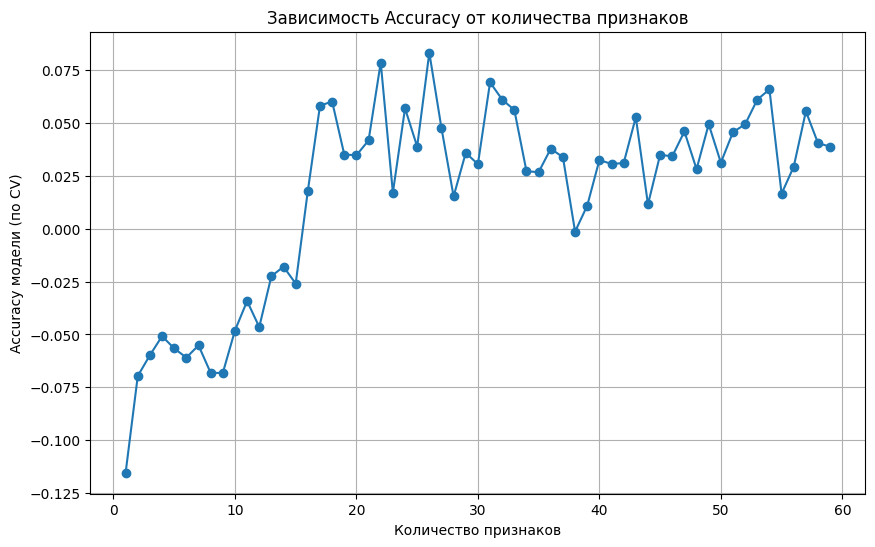

In [69]:
plt.figure(figsize=(10, 6))
plt.xlabel("Количество признаков")
plt.ylabel("Accuracy модели (по CV)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o')
plt.grid(True)
plt.title("Зависимость Accuracy от количества признаков")
plt.show()

#### Random Forest

---



In [15]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**param)

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='matthews_corrcoef')

    return scores.mean()

In [ ]:
study_3 = optuna.create_study(direction='maximize')
study_3.optimize(objective, n_trials=250)

print("Лучшие гиперпараметры:")
print(study_3.best_params)

In [76]:
#RF_model = RandomForestClassifier(**study_3.best_params, random_state = 42)

RF_model = RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=29,
                       min_samples_leaf=2, min_samples_split=11,
                       n_estimators=115, random_state=42)

RF_model.fit(X_train, y_train)

# Оценка на тестовой выборке
y_pred = RF_model.predict(X_test)
print("MCC на тесте:", matthews_corrcoef(y_test, y_pred))

MCC на тесте: 0.5962427794675942


In [75]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(RF_model, X, y, cv=skf, scoring='matthews_corrcoef')
for i in range(5):
  print(f'Fold {i+1}: MCC = {scores[i]}')
print('Mean MCC:', scores.mean())

Fold 1: MCC = 0.4368307075364568
Fold 2: MCC = 0.27814779759686326
Fold 3: MCC = 0.335648539012593
Fold 4: MCC = 0.5662696268762617
Fold 5: MCC = 0.2589465132975948
Mean MCC: 0.3751686368639539


In [81]:
from sklearn.feature_selection import RFECV

cv = StratifiedKFold(n_splits=5)

rfecv = RFECV(estimator=RF_model, step=1, cv=cv, scoring='matthews_corrcoef')
rfecv.fit(X, y)

# Результаты
print("Оптимальное количество признаков:", rfecv.n_features_)
print("Выбранные признаки:", X.columns[rfecv.support_].tolist())
RF_sel_features = X.columns[rfecv.support_].tolist()

Оптимальное количество признаков: 38
Выбранные признаки: ['AA', 'AC', 'AG', 'AT', 'CC', 'CT', 'GA', 'GC', 'GG', 'GT', 'TC', 'TG', 'TT', 'lipinskiHBD', 'NumRotatableBonds', 'NumHeavyAtoms', 'NumAtoms', 'NumHeteroatoms', 'NumAmideBonds', 'FractionCSP3', 'NumAliphaticRings', 'NumSaturatedRings', 'NumAliphaticHeterocycles', 'NumSpiroAtoms', 'NumUnspecifiedAtomStereoCenters', 'labuteASA', 'CrippenClogP', 'CrippenMR', 'chi0v', 'chi2v', 'chi3v', 'chi4v', 'chi0n', 'chi1n', 'chi2n', 'chi3n', 'chi4n', 'kappa3']


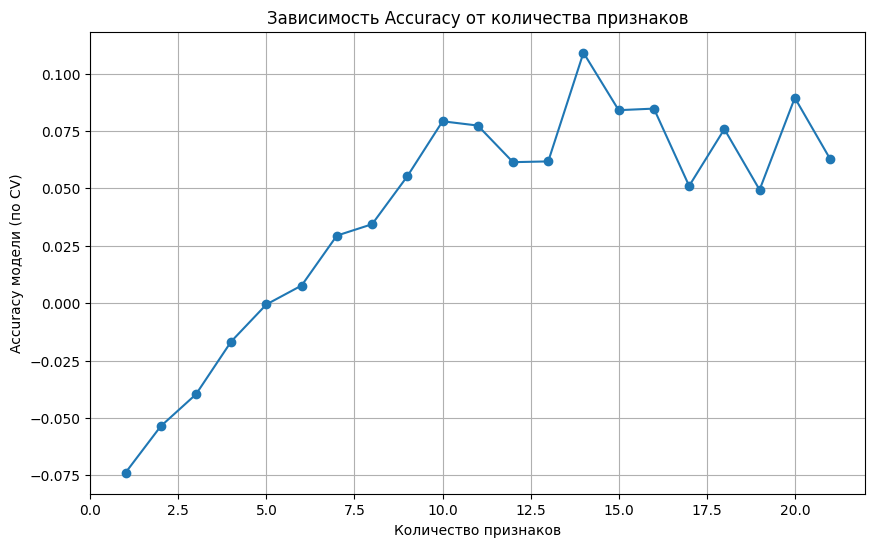

In [74]:
# Визуализация
plt.figure(figsize=(10, 6))
plt.xlabel("Количество признаков")
plt.ylabel("Accuracy модели (по CV)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o')
plt.grid(True)
plt.title("Зависимость Accuracy от количества признаков")
plt.show()

In [82]:
models = [LGBM_model, RF_model]
models_names = ['LGBM', 'Random_Forest']
selected_features_list = [LGBM_sel_features, RF_sel_features]

def get_metrics(models_list, models_names, selected_features_list):
  roc_auc_metrics = []
  f1_score_metrics = []
  precision_metrics = []
  recall_metrics = []
  mcc_metrics = []
  FP = []
  FN = []
  TP = []
  TN = []

  for model, features in zip(models_list, selected_features_list):
    model.fit(X_train[features], y_train)
    y_proba = model.predict_proba(X_test[features])[:, 1]
    y_pred = model.predict(X_test[features])

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    roc_auc_metrics.append(roc_auc_score(y_test, y_proba))
    f1_score_metrics.append(f1_score(y_test, y_pred))
    precision_metrics.append(precision_score(y_test, y_pred))
    recall_metrics.append(recall_score(y_test, y_pred))
    mcc_metrics.append(matthews_corrcoef(y_test, y_pred))
    FP.append(fp)
    FN.append(fn)
    TN.append(tn)
    TP.append(tp)

  data = pd.DataFrame({
    'model': models_names,
    'roc/auc': roc_auc_metrics,
    'f1': f1_score_metrics,
    'precision': precision_metrics,
    'recall': recall_metrics,
    'mcc': mcc_metrics,
    'TN': TN,
    'FP': FP,
    'FN': FN,
    'TP': TP
    })

  return data

In [83]:
results = get_metrics(models, models_names, selected_features_list)

In [84]:
results

,model,roc/auc,f1,precision,recall,mcc,TN,FP,FN,TP
0,LGBM,0.766613,0.464286,0.520000,0.419355,0.394290,188,12,18,13
1,Random_Forest,0.782742,0.530612,0.722222,0.419355,0.501484,195,5,18,13


In [85]:
import joblib

joblib.dump(RF_model, 'seq_model.pkl')

['seq_model.pkl']